# Introduction to cuML Random Forest and cuDF DataFrames

RAPIDS is an open-source data analytics and machine learning acceleration platform which leverages Graphical Processing Units (GPUs) to accelerate computations. RAPIDS is based on Python, and mimics the APIs of popular data analytics and machine learning Python packages such as Pandas and Scikit-Learn. RAPIDS can scale from 1 to multi-GPU to multi-nodes. RAPIDS is particularly usefule because of it's end-end workflow - from data prep, to machine learning, to deep learning. 

In this notebook we will first discuss cuDF, the pandas-like data analytics and processing package. We will show how to import data from a csv to a GPU-based DataFrame. Then we will discuss and implement a simple Random Forest Classification model. We will train this Random Forest model from sample remote-sensing data. We will then save the Random Forest model and demonstrate how to load and reuse the model using [joblib](https://joblib.readthedocs.io/en/latest/) 

For additional information on RAPIDS cuDF, refer to the [cuDF docs](https://docs.rapids.ai/api/cudf/stable)

For additional information on RAPIDS cuML's Random Forest model, see [cuML Random Forest Regressor](https://docs.rapids.ai/api/cuml/stable/api.html#random-forest)

In [1]:
import cudf
import cupy as cp

from cuml.ensemble import RandomForestRegressor as curfr
from cuml.metrics import mean_squared_error, r2_score
from cuml import train_test_split

import joblib
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import random

!nvidia-smi

Mon Dec 14 09:11:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:61:00.0 Off |                    0 |
| N/A   37C    P0    39W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:62:00.0 Off |                    0 |
| N/A   38C    P0    41W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Import Data

In this demo, we have the option of using one of two datasets ('aviris_bands_extract_final.csv', 'train_validate_10_final.csv') from the \'Data\' folder. This data is a sample of bands used to train our model to predict lake depth from raster data. 

The datasets are different in the fact that 'aviris_bands_extract_final' samples 390 spectral bands, while 'train_validate_10_final.csv' samples only 10. You can switch the notebook to use one of the two. Notice how well the GPU model deals with large data speed-wise. 

Note: Be wary that the permutation cell block will be very slow on the large dataset due to us using a cpu-based function. 

In this example, we will highlight two ways to import data to a GPU-based DataFrame.

The first method is to import directly using cuDF's `read_csv()` function. A second method, more geared to those familiar with Pandas, is to import data to a Pandas DataFrame then convert the CPU-based DataFrame to a cuDF GPU-based DataFrame.

Notice the timing difference between a CPU-based read with a shift to GPU memory and a direct read to GPU memory.

In [2]:
%%time
df_pandas = pd.read_csv('Data/train_validate_10_final.csv') # A much smaller dataset
#df_pandas = pd.read_csv('Data/aviris_bands_extract_final.csv') # Read the csv into a pandas DataFrame
cudf_df = cudf.DataFrame.from_pandas(df_pandas) # Read the Pandas DF to GPU memory as a cuDF DataFrame

CPU times: user 2.4 s, sys: 2.23 s, total: 4.63 s
Wall time: 1min 31s


In [3]:
%%time 
gpu_dataset = cudf.read_csv('Data/train_validate_10_final.csv') # Smaller dataset
#gpu_dataset = cudf.read_csv('Data/aviris_bands_extract_final.csv') # Read the csv directly into GPU memory
gpu_dataset = gpu_dataset.astype(cp.float32)

CPU times: user 8.12 ms, sys: 16.1 ms, total: 24.2 ms
Wall time: 226 ms


Since we were creating two seperate examples of the same data, we can get rid of one the first example.

In [4]:
df_pandas = None
cudf_df = None

Now that we have the dataset loaded into GPU memory. Let's poke around at our data using cuDF's handy functions. 

In [5]:
gpu_dataset.head(5)

,depth_m,b59_ang201,b60_ang201,b61_ang201,b62_ang201,b65_ang201,b67_ang201,b73_ang201,b74_ang201,b76_ang201,b78_ang201
0,0.766572,0.033982,0.033714,0.032013,0.031970,0.027843,0.024982,0.013986,0.014606,0.014061,0.014546
1,0.717804,0.033982,0.033714,0.032013,0.031970,0.027843,0.024982,0.013986,0.014606,0.014061,0.014546
2,0.859536,0.026502,0.026912,0.025114,0.025549,0.021589,0.020254,0.011278,0.011378,0.011042,0.011603
3,0.777240,0.027229,0.027591,0.025463,0.024831,0.021866,0.020672,0.012735,0.012505,0.012746,0.012870
4,0.649224,0.031175,0.031153,0.030272,0.029274,0.025335,0.023088,0.010361,0.011387,0.011305,0.011338


Looking at the above sample. We can see that we have the depth_m which will act as our training predictor. We also have 390 different AVIRIS bands to work with.

Since we're going to want to train with this data, we need to split the data up from the covariates (AVIRIS bands) and the training predictors (depth_m). We can do this very easily using the Pandas-like API.

In [6]:
training_predictors = gpu_dataset['depth_m']
covariates = gpu_dataset.drop(['depth_m'], axis=1)

That was simple. Now let's look at what we can do with some more cuDF functions. 

In [7]:
training_predictors.describe()

count    5243.000000
mean        1.373884
std         0.429527
min         0.470408
25%         1.099565
50%         1.475230
75%         1.743460
max         2.097020
Name: depth_m, dtype: float64

In [8]:
%%time

covariates.describe()

CPU times: user 311 ms, sys: 80 ms, total: 391 ms
Wall time: 10.1 s


,b59_ang201,b60_ang201,b61_ang201,b62_ang201,b65_ang201,b67_ang201,b73_ang201,b74_ang201,b76_ang201,b78_ang201
count,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000,5243.000000
mean,0.031550,0.031185,0.029731,0.029375,0.026706,0.024247,0.013804,0.014180,0.014116,0.014009
std,0.004561,0.004575,0.004461,0.004481,0.004184,0.004098,0.003248,0.003330,0.003392,0.003391
min,0.022300,0.022247,0.021359,0.020706,0.017501,0.015925,0.004294,0.004750,0.004613,0.003249
25%,0.028299,0.027867,0.026529,0.026120,0.023692,0.021381,0.012834,0.013126,0.013113,0.013022
50%,0.030487,0.030170,0.028726,0.028313,0.025637,0.023053,0.013932,0.014245,0.014120,0.013994
75%,0.033626,0.033244,0.031814,0.031538,0.028830,0.026363,0.015050,0.015408,0.015316,0.015153
max,0.051969,0.051937,0.052641,0.053870,0.066151,0.079642,0.105788,0.107176,0.112849,0.115969


In order to train and test the Random Forest model, we'll need to split the data into training and testing data. Fortunately, cuML implements this function, which operates exactly like Scikit-Learn's `train_test_split`

In [10]:
X_train, X_test, y_train, y_test = train_test_split(covariates, 
                                                    training_predictors, 
                                                    shuffle=True, 
                                                    train_size = 0.8)

In [11]:
print('Training features shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Testing features shape: ', X_test.shape)
print('Testing labels shape: ', y_test.shape)

Training features shape:  (4194, 10)
Training labels shape:  (4194,)
Testing features shape:  (1049, 10)
Testing labels shape:  (1049,)


## cuML Random Forest Regressor

Here we're going to initialize and fit the cuML model. Given the speed-up we get from GPU-based computations, we can afford a large Random Forest. 

Note: Igonore the warnings you may get with this.

In [12]:
%%time

cuml_model = curfr(n_estimators=1000,
                  max_depth = 50,
                  max_features = 'auto',
                  random_state = 42)

cuml_model.fit(X_train, y_train)

/home/cssprad1/.conda/envs/rapids-0.16/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams==1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  after removing the cwd from sys.path.


CPU times: user 7.11 s, sys: 5.11 s, total: 12.2 s
Wall time: 5.09 s


RandomForestRegressor(split_criterion=2, accuracy_metric='r2', handle=<cuml.raft.common.handle.Handle object at 0x7fd6b3fdaa30>, verbose=4, output_type='cudf')

### Evaluate

In [13]:
%%time

predictions = cuml_model.predict(X_test)

mae_cuml_model = mean_squared_error(y_test, predictions)
r2_cuml_model = r2_score(y_test, predictions)

CPU times: user 2.54 s, sys: 858 ms, total: 3.4 s
Wall time: 3.35 s


### Saving and loading a cuML model

Here we're going to use joblib to save and load out random forest model.

In [14]:
filename = 'Models/cuml_aviris_random_forest.sav'
# Save the trained model into a file
joblib.dump(cuml_model, open(filename, 'wb'))
# Delete the previous model to ensure there is no leakage of pointers. 
del cuml_model
# Load the saved pre-trained model from a file
saved_cuml_model = joblib.load(open(filename, 'rb'))

### Predictions after being saved

In [15]:
%%time 

prediction_post_save = saved_cuml_model.predict(X_test)

mae_post_save = mean_squared_error(y_test, prediction_post_save)
r2_post_save = r2_score(y_test, prediction_post_save)

CPU times: user 344 ms, sys: 80.8 ms, total: 424 ms
Wall time: 420 ms


# Compare and examine results

In [16]:
print('CUML mean absolute error of RF model before saving: %s' % mae_cuml_model)
print('CUML mean absolute error of RF model after saving: %s' % mae_post_save)

print('CUML r^2 score of RF model before saving: %s' % r2_cuml_model)
print('CUML r^2 score of RF model after saving: %s' % r2_post_save)

CUML mean absolute error of RF model before saving: 0.058456495
CUML mean absolute error of RF model after saving: 0.058456495
CUML r^2 score of RF model before saving: 0.6893738508224487
CUML r^2 score of RF model after saving: 0.6893738508224487


## Results Visualization

Here we can use JupyterHub to examine plots inline.

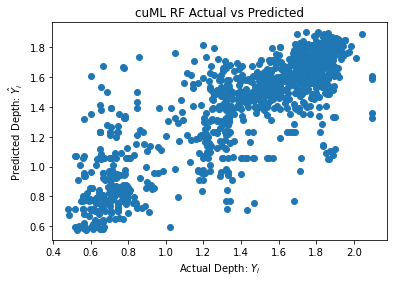

In [17]:
plt.scatter(y_test.to_array(), predictions.to_array())
plt.xlabel("Actual Depth: $Y_i$")
plt.ylabel("Predicted Depth: $\hat{Y}_i$")
plt.title("cuML RF Actual vs Predicted")
plt.show()

Let's look at a random sample of datapoints to see the actual vs predicted depths

In [18]:
# Lets look at a random sample of datapoints to see the actual vs predicted depths
for i in range(20):
    random_data_point = random.randint(0, 1049)
    print('Data-point: {:5} Actual: {:20} Predicted: {}'.format(random_data_point, y_test.to_array()[random_data_point],
                                               predictions.to_array()[random_data_point]))

Data-point:   183 Actual:    1.767840027809143 Predicted: 1.3553369045257568
Data-point:  1007 Actual:   0.7924799919128418 Predicted: 1.1231991052627563
Data-point:  1037 Actual:   1.5788600444793701 Predicted: 1.6620885133743286
Data-point:   424 Actual:    1.575819969177246 Predicted: 1.5628933906555176
Data-point:   785 Actual:   1.5057100057601929 Predicted: 1.4310120344161987
Data-point:   281 Actual:   1.7861299514770508 Predicted: 1.6622835397720337
Data-point:    38 Actual:   0.4846319854259491 Predicted: 0.679193377494812
Data-point:   817 Actual:   1.8074599504470825 Predicted: 1.9002385139465332
Data-point:     1 Actual:   1.4673800468444824 Predicted: 0.7570716142654419
Data-point:  1043 Actual:   1.8867100477218628 Predicted: 1.8417524099349976
Data-point:   822 Actual:   1.0302200317382812 Predicted: 1.3960161209106445
Data-point:   575 Actual:   1.2511999607086182 Predicted: 1.4458823204040527
Data-point:   390 Actual:   1.7434600591659546 Predicted: 1.5082930326461792


# Using sklearn with GPU models

### We can use most of sklearn's tools on our cuML models, one example being permutation importance!

Find the permutation importance using sklearn's implementation (works with cuML models)

In [19]:
%%time

perm_imp = permutation_importance(saved_cuml_model, X_test, y_test)
spectral_bands_list = list(covariates.columns)
importances = perm_imp.importances_mean
feature_importances = [(feature, (round(importance, 5))) for
                      feature, importance in zip(spectral_bands_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
_ = [print('Variables: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variables: b73_ang201           Importance: 0.50372
Variables: b78_ang201           Importance: 0.27456
Variables: b67_ang201           Importance: 0.25601
Variables: b60_ang201           Importance: 0.19258
Variables: b61_ang201           Importance: 0.14684
Variables: b59_ang201           Importance: 0.14522
Variables: b65_ang201           Importance: 0.11431
Variables: b76_ang201           Importance: 0.09285
Variables: b74_ang201           Importance: 0.08402
Variables: b62_ang201           Importance: 0.03812
CPU times: user 12.8 s, sys: 1.93 s, total: 14.7 s
Wall time: 14.7 s
